# Kronecker-based Compressed Sensing signal recovery

In this notebook we explore the _compression_ and _recovery_ of aCompressive Sensing _compressible_ signal through __Compressive Sensing__ with __Kronecker Technique__

#### Utilities

In [764]:
def printFormatted(matrix, decimals=4):
    """
    Prints the matrix with formatted elements aligned in columns for improved readability.

    Requires:
    ----------
    numpy as np
    

    Parameters:
    ----------
    matrix : numpy array
        The matrix to be printed.
    decimals : int, optional (default=4)
        The number of decimal places for formatting the elements.

    Notes:
    -----
    - The function aligns columns based on the maximum width needed for the formatted elements, ensuring the matrix is displayed neatly.
    - This function is useful for visual inspection of numerical matrices, especially those with varying magnitudes.
    """
    # Determine the maximum width needed to keep alignment
    max_width = max(len(f'{value:.{decimals}f}') for row in matrix for value in row)

    # Create a formatted string for each element in the matrix, ensuring alignment
    formatted_matrix = '\n'.join([' '.join([f'{value:>{max_width}.{decimals}f}' for value in row]) for row in matrix])

    # Print the formatted matrix
    print(formatted_matrix)


### Generate a random sparse signal

In [765]:
import numpy as np

def sparseSignal(N, K=None, sigma_inactive=0.01, sigma_active=0.5, fixedActiveValue=None):
    """
    Generates a K-sparse signal with N-K inactive components, chosen randomly. The inactive components 
    are nearly zero, while the active components are either a fixed value or generated from a Gaussian
    distribution.

    Requires:
    ----------
    numpy as np
    

    Parameters:
    ----------
    N : int
        The total number of components in the signal.
    
    K : int, optional
        The number of active (non-zero) components in the signal. If not provided, defaults to 10% of `N`.
    
    sigma_inactive : float, optional (default=0.01)
        The standard deviation of the Gaussian noise added to the inactive components.
    
    sigma_active : float, optional (default=0.5)
        The standard deviation of the Gaussian noise for generating the active components, if `fixedActiveValue` 
        is not provided.
    
    fixedActiveValue : float, optional
        If provided, this fixed value is assigned to all active components instead of generating them randomly.

    Returns:
    -------
    signal : numpy array
        The generated signal of length `N` with `K` active components.
    
    active_indices : numpy array
        The indices of the active components in the signal.

    Notes:
    -----
    - The signal is constructed by first randomly selecting `K` indices as active components.
    - If `fixedActiveValue` is `None`, the active components are drawn from a Gaussian distribution 
      with standard deviation `sigma_active`.
    - Gaussian noise with standard deviation `sigma_inactive` is then added to the inactive components, 
      ensuring they have small random values near zero.

    """

    if K is None:
        N = int(N)
        K = int(0.1 * N)
    else:
        N = int(N)
        K = int(K)

    active_indexes = np.zeros(N)
    active_indexes[:K] = 1
    np.random.shuffle(active_indexes)

    signal = np.zeros(N)
    
    if fixedActiveValue is None:
        # Generate active components with Gaussian noise
        signal[active_indexes == 1] = np.random.randn(K) * sigma_active
    else:
        # Use fixed value for active components
        signal[active_indexes == 1] = fixedActiveValue
    
    # Add Gaussian noise only to inactive components
    signal[active_indexes == 0] += np.random.randn(N - K) * sigma_inactive

    return signal, np.where(active_indexes == 1)[0]


Test the above function

Maximum value in the signal: 0.6348884274253517


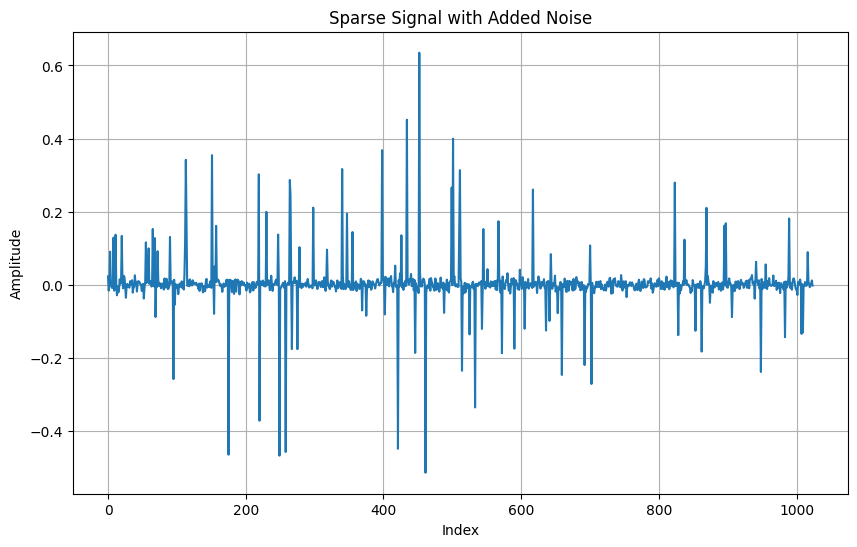

In [766]:
import numpy as np
import matplotlib.pyplot as plt

# Set the random seed for reproducibility
np.random.seed(42)

# Parameters for the sparse signal
N = 2 ** 10
K = int(0.1 * N)
sigma_noise = 0.01
sigma_active = 0.2
fixedActiveValue = None

# Generate the sparse signal
x, active_indices = sparseSignal(N, K, sigma_noise, sigma_active, fixedActiveValue)

# Display the full signal array (optional, since it's very large)
#np.set_printoptions(threshold=np.inf)  # Setting the threshold to infinity to display the full array
#print("Signal: ", x)
#print("Active indices: ", active_indices)

# Print the maximum value in the signal
print("Maximum value in the signal:", np.max(x))

# Plot the sparse signal
plt.figure(figsize=(10, 6))
plt.plot(x)
plt.title('Sparse Signal with Added Noise')
plt.xlabel('Index')
plt.ylabel('Amplitude')
plt.grid(True)
plt.show()



#### Measurement matrix

In [767]:
import numpy as np

def generate_DBDD_matrix(M, N):
    """
    Generates a deterministic Diagonally Blocked Block Diagonal (DBBD) matrix.

    Requires:
    ----------
    numpy as np


    Parameters:
    ----------
    M : int
        Number of rows in the matrix.
    N: int
        Number of columns in the matrix. Should be a multiple of M.

    Returns:
    -------
    A : numpy array
        The generated DBBD matrix of shape (M, N).
    """
    
    if N % M != 0:
        raise ValueError("N should be a multiple of M.")
    
    Phi = np.zeros((M, N))
    m = N // M
    
    for i in range(M):
        Phi[i, i*m:(i+1)*m] = 1

    return Phi


import numpy as np

def generate_random_matrix(M, N, matrix_type='gaussian'):
    """
    Generates a random matrix based on the specified type.

    Requires:
    ----------
    numpy as np
    

    Parameters:
    ----------
    M : int
        Number of rows in the matrix.
    N : int
        Number of columns in the matrix.
    matrix_type : str, optional (default='gaussian')
        The type of random matrix to generate. Options are:
        - 'gaussian': A matrix with entries drawn from a normal distribution.
        - 'scaled_binary': A matrix with binary entries (±0.5), scaled by 1/sqrt(M).
        - 'unscaled_binary': A matrix with binary entries (±1), with no scaling.

    Returns:
    -------
    A : numpy array
        The generated random matrix of shape (M, N).
    """
    
    if matrix_type == 'gaussian':
        A = ((1/M)**2) * np.random.randn(M, N)

    elif matrix_type == 'scaled_binary':
        A = np.random.binomial(1, 0.5, size=(M, N)) - 0.5
        A = (1/np.sqrt(M)) * A

    elif matrix_type == 'unscaled_binary':
        A = np.random.binomial(1, 0.5, size=(M, N)) * 2 - 1
        # This generates -1 or +1 directly without scaling

    else:
        raise ValueError("Unsupported matrix type. Choose either 'gaussian', 'scaled_binary', or 'unscaled_binary'.")

    return A



Test above code

In [768]:
N = 2 ** 4
M = N // 4

# Generate a deterministic DBBD matrix
A = generate_DBDD_matrix(M, N)
print(f'DBBD:\n{A}\n\n')

# Generate a random Gaussian matrix
B = generate_random_matrix(M, N, matrix_type='gaussian')
print(f'gaussian:\n{B}\n\n')

# Generate a random scaled binary matrix
C = generate_random_matrix(M, N, matrix_type='scaled_binary')
print(f'scaled binary:\n{C}\n\n')

# Generate a random unscaled binary matrix
D = generate_random_matrix(M, N, matrix_type='unscaled_binary')
print(f'unscaled binary:\n{D}\n\n')


DBBD:
[[1. 1. 1. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 1. 1. 1. 1. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 1. 1. 1. 1. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 1. 1. 1.]]


gaussian:
[[-0.04486396 -0.03027256  0.06581609  0.12708158 -0.08210986 -0.06845635
  -0.0105498   0.00693476  0.0491856  -0.05569581 -0.06644431  0.00863045
  -0.01615005  0.05792006  0.03045999  0.03471121]
 [-0.00653008  0.14722377 -0.05235925  0.03817561 -0.07935562 -0.06709173
  -0.0379591   0.10183271  0.0164934  -0.03690488  0.02340227  0.00219674
  -0.03074834 -0.0872893   0.08990891  0.01311363]
 [ 0.13585865  0.0587701   0.03445748 -0.02720027 -0.0684591  -0.01360819
  -0.07026829  0.0406369   0.10204078 -0.01630702  0.05903069 -0.04307682
  -0.01890418 -0.05093525 -0.13332081 -0.00228333]
 [ 0.00802823  0.06661631  0.04971489  0.05055956 -0.06087726  0.02871858
   0.09891212  0.02374174  0.1142871   0.12618538 -0.01677927 -0.04355873
  -0.04759139 -0.09475849 -0.032

#### Generate dictionary

DCT

In [769]:
import numpy as np
import scipy.fftpack as fftpack

def generate_dct_dictionary(N):
    """
    Generates a Discrete Cosine Transform (DCT) basis dictionary.

    Requires:
    ----------
    numpy as np
    scipy.fftpack as fftpack

    
    Parameters:
    ----------
    N : int
        The size of the dictionary (i.e., the length of the signal).

    Returns:
    -------
    dict_matrix : numpy array
        The generated DCT dictionary matrix of shape (N, N).
    """
    
    # Generate a DCT basis dictionary
    dict_matrix = fftpack.dct(np.eye(N), norm='ortho')
    
    return dict_matrix


Haar wavelet dictionary, BEWARE: it's orthogonal but __not normalized__

In [770]:
import numpy as np

def generate_haar_basis(dim):
    """
    Generates a Haar orthogonal basis matrix of given dimension.

    Requires:
    ----------
    numpy as np
  

    Parameters:
    ----------
    dim : int
        The dimension of the basis (i.e., the length of the signal and the size of the matrix).

    Returns:
    -------
    haar_basis : numpy array
        The generated Haar orthogonal basis matrix of shape (dim, dim).

    Raises:
    -------
    ValueError
        If the dimension `dim` is not a power of 2.

    Notes:
    -----
    - This implementation generates an orthogonal Haar basis, where the first row represents
      the DC component (all ones, scaled by the square root of the dimension). 
    - The subsequent rows are Haar wavelet-like functions with alternating positive and 
      negative values.
    - While the basis is orthogonal (i.e., the inner product of any two distinct rows is zero),
      it is not orthonormal because the rows are not necessarily unit vectors.
    - Additionally, this approach does not guarantee sparsity in the basis, which is often 
      desired in wavelet transforms for signal compression or denoising.

    Warning:
    -------
    - Using this manually constructed Haar basis is generally not advisable. The traditional
      Haar wavelet basis generated using wavelet libraries like PyWavelets (pywt) is not only
      orthonormal but also designed to promote sparsity in signal representation.
    - For a more efficient and normalized Haar basis, consider using the `generate_dwt_basis`
      function with the option `wavelet='haar'`. This ensures a properly normalized and 
      sparse basis suitable for various signal processing applications.
    """

    # Check if the dimension is a power of 2
    if not np.log2(dim).is_integer():
        raise ValueError("Dimension must be a power of 2")

    # Initialize the Haar basis matrix
    haar_basis = np.zeros((dim, dim))

    # Set the first row of the Haar basis matrix (DC component)
    haar_basis[0, :] = 1 / np.sqrt(dim)

    # Generate the remaining rows of the Haar basis matrix
    for i in range(1, dim):
        k = int(np.log2(i))
        p = i - 2 ** k
        q = 2 ** (k + 1)

        for j in range(dim):
            if p < q / 2:
                haar_basis[i, j] = np.sqrt(2) / np.sqrt(q)
            else:
                haar_basis[i, j] = -np.sqrt(2) / np.sqrt(q)

            p += 1
            if p == q:
                p = 0

    return haar_basis


__ANY wavelet__ dictionary, choose which __wavelet__ and __level__

In [771]:
import numpy as np
import pywt

def generate_dwt_basis(dim, wavelet='db5', mode='per', level=None):
    """
    Generates a wavelet orthonormal basis matrix using the Discrete Wavelet Transform (DWT).

    Requires:
    --------
    - numpy (as np)
    - pywt (PyWavelets)
    

    Parameters:
    ----------
    dim : int
        The dimension of the basis (i.e., the length of the signal and the size of the matrix).
    
    wavelet : str, optional (default='db5')
        The name of the wavelet to use. Options include Daubechies wavelets ('db1' to 'db20') and
        other wavelet families available in PyWavelets.

    mode : str, optional (default='per')
        The signal extension mode to use when applying the wavelet transform. The default is
        'per' for periodic extension. Other options include 'zero', 'symmetric', etc.

    level : int, optional
        The level of decomposition to perform. If not provided (level=None), the function sets
        the level to log2(dim). If a value is provided, it should be an integer greater than 0.
        If the provided level is greater than log2(dim), the function resets it to log2(dim).

    Returns:
    -------
    basis_matrix : numpy array
        The generated wavelet basis matrix of shape (dim, dim). Each column of this matrix 
        represents a wavelet basis vector for the given wavelet and decomposition level.

    Raises:
    -------
    ValueError
        If `dim` is not a power of 2, or if `level` is not an integer greater than 0.

    Notes:
    -----
    - This function assumes that `dim` is a power of 2. If it is not, the function raises a ValueError.
    - If the decomposition level is not provided, it defaults to log2(dim), ensuring a full decomposition.
    - The function constructs the basis by applying the wavelet transform to each standard basis vector
      (i.e., the columns of the identity matrix) and concatenating the resulting coefficients into the
      final basis matrix.

    Changes Made:
    -------------
    - Added validation for `dim` to ensure it is a power of 2.
    - Added checks for the `level` parameter to ensure it is a positive integer and does not exceed log2(dim).
    - The function now defaults to log2(dim) if the level is not provided or is greater than log2(dim).
    - These changes ensure that the function behaves robustly across various input cases, providing users
      with informative feedback and corrections as necessary.
    """

    # Check if the dimension is a power of 2
    if not np.log2(dim).is_integer():
        raise ValueError("Dimension must be a power of 2")

    # Check if level is provided and valid
    if level is None:
        print("Level is not provided, setting level to log2(dim)")
        level = int(np.log2(dim))
        print()
    elif level < 1:
        raise ValueError("Level should be an integer greater than 0, level=None => level=log2(dim)")
    elif level > int(np.log2(dim)):
        print("Level provided is greater than max_level=log2(dim) => setting level to log2(dim)")
        level = int(np.log2(dim))

    # Initialize the basis matrix
    basis_matrix = np.zeros((dim, dim))
    
    for i in range(dim):
        # Apply wavelet transform to each basis vector
        coeffs = pywt.wavedec(data=np.eye(dim)[:, i], wavelet=wavelet, mode=mode, level=level, axis=0)
        
        # Flatten the coefficients and assign to the corresponding column in the basis matrix
        basis_matrix[:, i] = np.hstack(coeffs)
    
    return basis_matrix


Function that calls the previous to generate the desired dictionary

In [772]:
def generate_basis(DIM, basis_type='dct', wavelet='db5', mode='per', level=None):
    """
    Generates a basis matrix based on the specified type.

    Requires:
    ----------
    generate_dct_dictionary
    generate_haar_basis
    generate_dwt_basis

    Parameters:
    ----------
    DIM : int
        The dimension of the basis (i.e., the length of the signal).
    
    basis_type : str, optional (default='dct')
        The type of basis to generate. Options are:
        - 'dct' for Discrete Cosine Transform basis
        - 'haar_classic' for Haar wavelet basis
        - 'dwt' for Daubechies wavelet basis

    wavelet : str, optional (default='db5')
        The name of the Daubechies wavelet to use if `basis_type='dwt'`.

    mode : str, optional (default='per')
        The extension mode to use if `basis_type='dwt'`.

    level : int or None, optional (default=None)
        The level of decomposition to use if `basis_type='dwt'`.

    Returns:
    -------
    basis_matrix : numpy array
        The generated basis matrix of shape (DIM, DIM).
    """
    
    if basis_type == 'dct':
        return generate_dct_dictionary(DIM)
    
    elif basis_type == 'haar_classic':
        return generate_haar_basis(DIM)
    
    elif basis_type == 'dwt':
        return generate_dwt_basis(DIM, wavelet=wavelet, mode=mode, level=level)
    
    else:
        raise ValueError(f"Unknown basis_type '{basis_type}'. Supported types are 'dct', 'haar_classic', and 'dwt'.")


Test above code

In [773]:
# compute reduction of matrix to independent columns
def compute_independent_columns(A, tol=1e-10):
    """
    Computes the independent columns of a matrix using the QR decomposition.

    Requires:
    ----------
    numpy as np


    Parameters:
    ----------
    A : numpy array
        The matrix for which to compute the independent columns.
    tol : float, optional (default=1e-10)
        The tolerance value for considering singular values as zero.

    Returns:
    -------
    ind_cols : numpy array
        The matrix containing the independent columns of A.

    Notes:
    -----
    - The function uses the QR decomposition to identify and select the independent columns of the matrix `A`.
    - The rank of the matrix is determined by checking the diagonal elements of the `R` matrix from the QR decomposition.
    - Columns corresponding to non-zero diagonal elements of `R` are considered independent.
    """
    # Perform the QR decomposition
    Q, R = np.linalg.qr(A)

    # Find the independent columns based on the rank of R
    rank = np.sum(np.abs(np.diagonal(R)) > tol)
    ind_cols = A[:, :rank]

    return ind_cols


def check_normalization(A):
    """
    Checks if the columns of a matrix are normalized (i.e., each column has a unit norm).

    Requires:
    ----------
    numpy as np

    Parameters:
    ----------
    A : numpy array
        The matrix to check for normalization.

    Returns:
    -------
    is_normalized : bool
        True if the columns of A are normalized, False otherwise.

    Notes:
    -----
    - The function calculates the norm of each column in the matrix `A`.
    - It then checks if all column norms are close to 1.0, which indicates normalization.
    """
    column_norms = np.linalg.norm(A, axis=0)
    is_normalized = np.allclose(column_norms, 1.0)
    return is_normalized


def compute_coherence(matrix):
    """
    Computes the coherence of the given matrix.
    
    Parameters:
    matrix (numpy.ndarray): An N x M matrix where coherence is to be calculated.
    
    Returns:
    float: The coherence of the matrix.
    """
    # Normalize the columns of the matrix
    normalized_matrix = matrix / np.linalg.norm(matrix, axis=0, keepdims=True)
    
    # Compute the Gram matrix (inner products between all pairs of columns)
    gram_matrix = np.dot(normalized_matrix.T, normalized_matrix)
    
    # Remove the diagonal elements (which are all 1's) to only consider distinct columns
    np.fill_diagonal(gram_matrix, 0)
    
    # Compute the coherence as the maximum absolute value of the off-diagonal elements
    coherence = np.max(np.abs(gram_matrix))
    
    return coherence



In [774]:

for DIM in range(1):
    
    DIM = 16  # DIM must be a power of 2
    
    print(f'DIM: {DIM}')


    for test in range(1):
        # Generate dictionary
        Dict = generate_basis(DIM, basis_type='dwt', wavelet='db10', mode='per', level=None)
        print(f'Dictionary shape: {Dict.shape}, test: {test}')
        #printFormatted(Dict, decimals=4)
        print()


        # Orthonormality test
        print("Orthonormality test")
        A = Dict

        # Check orthogonality
        rankA = np.linalg.matrix_rank(A)
        #print(f'Rank of A: {rankA}')
        if A.shape[0] == rankA or A.shape[1] == rankA:
            print("Matrix A is full rank.")
        #print(f'Original shape: {A.shape}')
        #A = compute_independent_columns(A)
        #A = compute_independent_columns(A.T)
        #print(f'Full rank shape: {A.shape}')
        #printFormatted(A, decimals=4)

        # Check normalization
        #print()
        is_normalized = check_normalization(A)
        print(f"Matrix A is normalized: {is_normalized}")
        is_normalized = check_normalization(A.T)
        print(f"Matrix A^T is normalized: {is_normalized}")
        print()


        # Coherence test
        print("Coherence test")
        coherence = compute_coherence(Dict)
        print(f'Coherence: {coherence}')



DIM: 16
Level is not provided, setting level to log2(dim)

Dictionary shape: (16, 16), test: 0

Orthonormality test
Matrix A is full rank.
Matrix A is normalized: True
Matrix A^T is normalized: True

Coherence test
Coherence: 1.4436730614985572e-16
Theoretical minimum coherence: 0.0
Ratio (Coherence / Theoretical minimum coherence): inf


/tmp/ipykernel_55245/380371.py:46: RuntimeWarning: divide by zero encountered in scalar divide
  print(f'Ratio (Coherence / Theoretical minimum coherence): {coherence / min_coherence}')


#### Sampling Phase

In [775]:
def compressSignal(signal,Phi):
    """
    """
    
    # length of signal block
    N = Phi.shape[1]

    # length of compressed block
    M = Phi.shape[0]

    # number of blocks
    BLOCK_NUM = len(signal) // N

    # each column of Y is the compressed version of a block of signal
    Y = np.zeros((M, BLOCK_NUM))    
    for i in range(BLOCK_NUM):
        Y[:,i] = Phi @ signal[i*N:(i+1)*N]
    
    return Y

#### Reconstruction method: Smooth-L0 (SL0)

In [776]:
import numpy as np

def SL0(y, A, sigma_min, sigma_decrease_factor=0.5, mu_0=2, L=3, A_pinv=None, showProgress=False):
    """
    Returns the sparsest vector `s` that satisfies the underdetermined system of 
    linear equations `A @ s = y`, using the Smoothed L0 (SL0) algorithm.

    Requires:
    --------
    - numpy as np
    

    Parameters:
    ----------
    y : numpy array
        The observed vector (Mx1), where M is the number of rows in `A`.
    
    A : numpy array
        The measurement matrix (MxN), which should be 'wide', meaning it has more 
        columns than rows (N > M). The number of rows in `A` must match the length 
        of `y`.
    
    sigma_min : float
        The minimum value of `sigma`, which determines the stopping criterion for 
        the algorithm. It should be chosen based on the noise level or desired 
        accuracy.
    
    sigma_decrease_factor : float, optional (default=0.5)
        The factor by which `sigma` is decreased in each iteration. This should be 
        a positive value less than 1. Smaller values lead to quicker reduction of 
        `sigma`, possibly at the cost of accuracy for less sparse signals.
    
    mu_0 : float, optional (default=2)
        The scaling factor for `mu`, where `mu = mu_0 * sigma^2`. This parameter 
        influences the convergence rate of the algorithm.
    
    L : int, optional (default=3)
        The number of iterations for the inner loop (steepest descent). Increasing 
        `L` can improve the precision of the result but also increases computational 
        cost.
    
    A_pinv : numpy array, optional
        The precomputed pseudoinverse of the matrix `A`. If not provided, it will be 
        calculated within the function as `np.linalg.pinv(A)`. Providing this value 
        is beneficial if the function is called repeatedly with the same `A`.
    
    showProgress : bool, optional (default=False)
        If `True`, the function prints the current value of `sigma` during each 
        iteration, which helps monitor the convergence process.

    Returns:
    -------
    s : numpy array
        The estimated sparse signal (Nx1) that best satisfies the equation `A @ s = y`.

    Notes:
    -----
    - The algorithm works by iteratively reducing `sigma` in a geometric sequence, 
      starting with `sigma = 2 * max(abs(s))` and ending with `sigma_min`. At each 
      step, the function adjusts `s` to minimize the L0-norm by smoothing it using 
      a Gaussian kernel.
    
    - The choice of `sigma_min` is crucial: for noiseless cases, a smaller `sigma_min` 
      yields a sparser solution; for noisy cases, `sigma_min` should be a few times 
      the standard deviation of the noise in `s`.

    - If `A_pinv` is precomputed and passed as an argument, the function becomes 
      more efficient, especially in scenarios where it is called repeatedly with the 
      same `A`.

    """

    if A_pinv is None:
        A_pinv = np.linalg.pinv(A)

    # Initialize the variables
    s = A_pinv @ y
    sigma = 2 * max(np.abs(s))

    # Define lambda function for delta
    OurDelta = lambda s, sigma: s * np.exp(-s**2 / sigma**2)
 
    # Main loop
    while sigma > sigma_min:
        for i in range(L):
            delta = OurDelta(s, sigma)
            s = s - mu_0 * delta
            s = s - A_pinv @ (A @ s - y)
        
        if showProgress:
            print(f'sigma: {sigma}')

        sigma = sigma * sigma_decrease_factor

    return s


Test SL0

#### Recovery

Non-kronecker

In [777]:
def non_kron_recovery(Y, sigma_min, Phi=None, Theta=None, Dict=None, 
                      basis_type='dwt', wavelet='db10', mode='per', level=None,
                      sigma_decrease_factor=0.5, mu_0=2, L=3, Theta_pinv=None, showProgress=False):


    ## Phi AS ARGUMENT
    # The only purpose of giving Phi as argument is to test the same Phi for different techniques (i.e. Kronecker, Dictionaries, etc.)

    # if Phi is None: both Theta and Dict should be provided
    if Phi is None:
        if Theta is None or Dict is None:
            raise ValueError("If Phi is not provided, both Theta and Dict should be provided.")
    elif Theta is None and Dict is None:
        n_block = Phi.shape[1]  # length of ORIGINAL signal block
        Dict = generate_basis(n_block, basis_type, wavelet, mode, level)
        Theta = Phi @ Dict
        Theta_pinv = np.linalg.pinv(Theta)    

    if Theta_pinv is None:
        Theta_pinv = np.linalg.pinv(Theta)

    # print shapes and matrices
    print(f'Y shape: {Y.shape}')
    print(f'Theta shape: {Theta.shape}')
    print(f'Dict shape: {Dict.shape}')
    print(f'Theta_pinv shape: {Theta_pinv.shape}')
    print()

    print("Y:")
    printFormatted(Y)
    print("Phi:")
    printFormatted(Phi)
    print("Theta:")
    printFormatted(Theta)
    print("Dict:")
    printFormatted(Dict)
    print("Theta_pinv:")
    printFormatted(Theta_pinv)
    print()




    ## IN THIS PARTICULARE CASE:
    # Y is a matrix of size m_block x BLOCK_NUM
    # Basically every column of Y is the compressed version of a block of signal

    # I DO NOT LIKE THIS, IN A MORE REALISTIC SCENARIO THE ECG MACHINE WOULD SHURELY STORE
    # Y AS A SINGLE ARRAY OF SIZE m_block*BLOCK_NUM, where every consecutive m_block samples
    # are the compressed version of a block of signal

    # THIS SHOULD BE CHANGED FOR BETTER REPRESENTATION
    # Maybe we should have a function that is able to understand if Y is a matrix or a vector
    # and act accordingly
    BLOCK_NUM = Y.shape[1]  # number of blocks



    n_block = Theta.shape[1]  # length of ORIGINAL signal block
    x_hat = np.zeros(BLOCK_NUM*Theta.shape[1])  # recoverd signal will be long as the original signal
    for i in range(BLOCK_NUM):
        y = Y[:, i]
        s_block = SL0(y, Theta, sigma_min, sigma_decrease_factor, mu_0, L, Theta_pinv, showProgress)
        x_hat[i*n_block:(i+1)*n_block] = Dict @ s_block
    
    return x_hat


Kronecker-based

In [778]:
def kron_recovery(Y,Theta_kron, Dict_kron, sigma_min, sigma_decrease_factor=0.5, mu_0=2, L=3, Theta_pinv=None, showProgress=False):

    n_block_kron = 0

#### Evaluation of results

SNR

In [779]:
import numpy as np

def calculate_snr(signal, recovered_signal):
    """
    Calculates the Signal-to-Noise Ratio (SNR) between the original signal and the recovered signal.

    Parameters:
    ----------
    signal : numpy array
        The original signal.
    recovered_signal : numpy array
        The recovered signal after some processing or recovery algorithm.

    Returns:
    -------
    snr : float
        The Signal-to-Noise Ratio (SNR) in decibels (dB).

    Notes:
    -----
    - The SNR is calculated as 20 * log10(norm(original_signal) / norm(original_signal - recovered_signal)).
    - A higher SNR value indicates a better recovery, with less error relative to the original signal.
    """
    error = recovered_signal - signal
    snr = 20 * np.log10(np.linalg.norm(signal) / np.linalg.norm(error))
    
    return snr


Plot recovered over original

In [780]:
import matplotlib.pyplot as plt
import numpy as np

def plot_signals(original_signal, reconstructed_signal, original_name="Original Signal", reconstructed_name="Reconstructed Signal"):
    """
    Plots the original signal and the reconstructed signal on the same plot with the given names.

    Requires:
    ----------
    - matplotlib.pyplot as plt
    - numpy as np

    Parameters:
    ----------
    original_signal : numpy array
        The original signal to be plotted.
    
    reconstructed_signal : numpy array
        The reconstructed signal to be plotted.
    
    original_name : str, optional (default="Original Signal")
        The name to display for the original signal in the plot.
    
    reconstructed_name : str, optional (default="Reconstructed Signal")
        The name to display for the reconstructed signal in the plot.
    """
    
    # Ensure the signals have the same length
    if len(original_signal) != len(reconstructed_signal):
        raise ValueError("The original signal and the reconstructed signal must have the same length.")
    
    # Create the plot
    plt.figure(figsize=(10, 6))
    plt.plot(original_signal, label=original_name, color='blue', linewidth=1.5)
    plt.plot(reconstructed_signal, label=reconstructed_name, color='red', linestyle='--', linewidth=1.5)
    plt.title(f"{original_name} vs {reconstructed_name}")
    plt.xlabel('Sample Index')
    plt.ylabel('Amplitude')
    plt.legend()
    plt.grid(True)
    plt.show()



#### Code execution

Signal shape: (2048,)


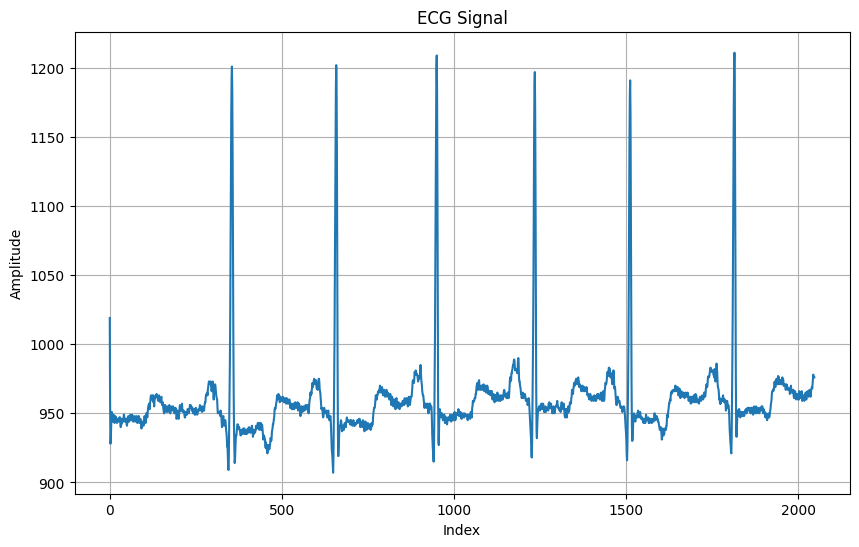

Phi shape: (4, 16)
Phi:
[[1. 1. 1. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 1. 1. 1. 1. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 1. 1. 1. 1. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 1. 1. 1.]]
Level is not provided, setting level to log2(dim)

Y shape: (4, 128)
Theta shape: (4, 16)
Dict shape: (16, 16)
Theta_pinv shape: (16, 4)

Y:
3834.0000 3787.0000 3771.0000 3771.0000 3790.0000 3781.0000 3771.0000 3824.0000 3834.0000 3837.0000 3819.0000 3812.0000 3798.0000 3817.0000 3806.0000 3808.0000 3808.0000 3812.0000 3889.0000 3876.0000 3799.0000 3761.0000 4682.0000 3753.0000 3744.0000 3753.0000 3741.0000 3759.0000 3730.0000 3710.0000 3817.0000 3841.0000 3836.0000 3814.0000 3823.0000 3813.0000 3810.0000 3894.0000 3880.0000 3803.0000 3779.0000 4722.0000 3764.0000 3780.0000 3770.0000 3775.0000 3773.0000 3760.0000 3819.0000 3873.0000 3857.0000 3836.0000 3835.0000 3828.0000 3832.0000 3894.0000 3901.0000 3826.0000 3826.0000 4145.0000 3794.0000 3786.0000 3788.0000 

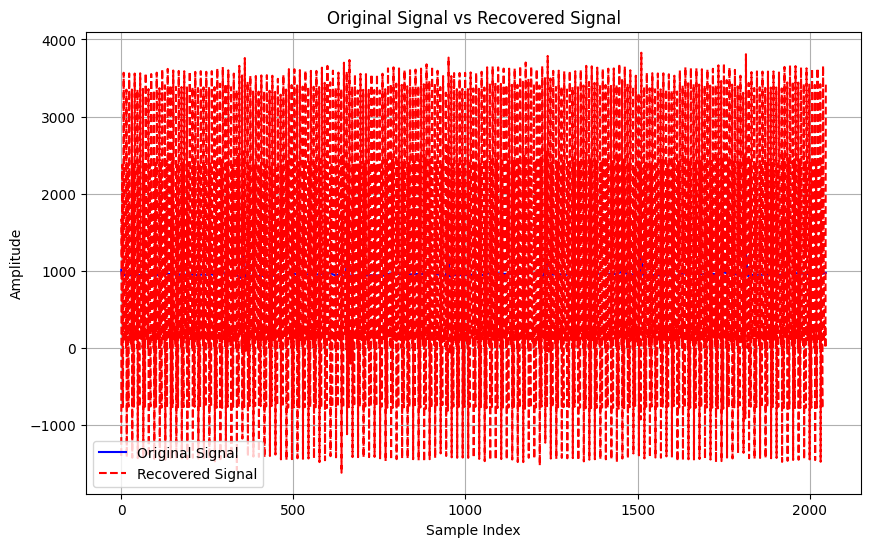

SNR: -3.4144831914626144 dB


In [781]:
import scipy.io
import matplotlib.pyplot as plt

if __name__ == "__main__":


    ### PREPARE
    # ----------------------------------------------------------------

    ## DATA
    #  upload data
    data = scipy.io.loadmat('100m.mat')
    # retrieve the key to a string
    key = list(data.keys())[0]
    # retrieve the values
    signal = data[key][0,:]  # [0 or 1, 0:650000] s.t. first dim: (0 is MLII, 1 is V5)
    # pick only 2048 samples, because it will be Kronecker block dimension
    start = int(512 * 4)
    end = int(start + 512*4)
    signal = signal[start:end]
    # print the shape of the signal
    print(f'Signal shape: {signal.shape}') 
    # plot the signal
    plt.figure(figsize=(10, 6))
    plt.plot(signal)
    plt.title('ECG Signal')
    plt.xlabel('Index')
    plt.ylabel('Amplitude')
    plt.grid(True)
    plt.show()    


    ## PARAMETERS
    # compression ratio
    CR = 1/4 
    # non-kronecker
    n_block = 16 # block size`
    m_block = int(n_block * CR) # compressed block size
    # kronecker
    n_block_kron = 512 # kron block size
    m_block_kron = int(n_block_kron * CR) # compressed kron block size
    kron_factor = n_block_kron // n_block # kron factor



    ### SAMPLING PHASE 
    # ----------------------------------------------------------------


    ## MEASUREMENT MATRIX
    # generate the measurement matrix
    Phi = generate_DBDD_matrix(m_block, n_block)
    #Phi = generate_random_matrix(m_block, n_block, matrix_type='gaussian')
    #Phi = generate_random_matrix(m_block, n_block, matrix_type='scaled_binary')
    #Phi = generate_random_matrix(m_block, n_block, matrix_type='unscaled_binary')

    print(f'Phi shape: {Phi.shape}')
    print(f'Phi:')
    print(Phi)


    ## COMPRESS THE SIGNAL
    # compress the signal
    Y = compressSignal(signal, Phi)



    ### RECOVERY PHASE
    # ----------------------------------------------------------------

    # note: OPTIONAL parameters that are not provided, are computed inside the functions

    ## DICTIONARY non-KRONECKER (optional)
    # generate the dictionary
    #Dict = generate_basis(n_block, basis_type='dwt', wavelet='db10', mode='per', level=None)
    #Dict = generate_basis(n_block, basis_type='haar_classic')
    #Dict = generate_basis(n_block, basis_type='dct')

    ## KRONECKER DICTIONARY (optional)
    # generate the dictionary
    #Dict_kron = generate_dct_dictionary(n_block_kron)
    #Dict_kron = generate_haar_basis(n_block_kron)
    #Dict_kron = generate_dwt_basis(n_block_kron, wavelet='haar', mode='per', level=None, axis=0)


    ## KRONECKER MEASUREMENT MATRIX (for reconstruction purpose only, REQUIRED)
    # generate the measurement matrix
    Phi_kron = np.kron(np.eye(kron_factor), Phi)

    
    ## THETA MATRIX (optional)
    # compute the theta matrix
    #Theta = Phi @ Dict
    #Theta_kron = Phi_kron @ Dict_kron


    ## SL0 PARAMETERS
    sigma_off = 0.001  # offset for sigma
    Phi_pinv = np.linalg.pinv(Phi)  # precompute the pseudoinverse of Phi
    Phi_kron_pinv = np.linalg.pinv(Phi_kron)  # precompute the pseudoinverse of Phi_kron
    mu_0 = 2  # scaling factor for mu
    sigma_decrease_factor = 0.5  # factor for decreasing sigma
    L = 3  # number of iterations for the inner loop
    if sigma_off > 0:
        sigma_min = sigma_off * 4  # minimum value of sigma
    else:
        sigma_min = 0.00001  # minimum value of sigma



    ## RECOVERY non-KRONECKER
    # recover the signal
    recovered_signal = non_kron_recovery(Y, sigma_min, Phi, Theta=None, Dict=None, basis_type='dwt',
                                          wavelet='db10', mode='per', level=None, sigma_decrease_factor=sigma_decrease_factor,
                                            mu_0=mu_0, L=L, Theta_pinv=None, showProgress=False)
    




    ### EVALUATION
    # ----------------------------------------------------------------

    

    ## PLOT
    # plot the signals
    plot_signals(signal, recovered_signal, original_name="Original Signal", reconstructed_name="Recovered Signal")

    ## SNR
    # calculate the SNR
    snr = calculate_snr(signal, recovered_signal)
    print(f'SNR: {snr} dB')
    

